# 前提
- 諸々理解するためのドラフトであり、整理されていないもの
- 気温とアイスクリーム売上の実績からベイズの回帰を行う

# 事前分布なし

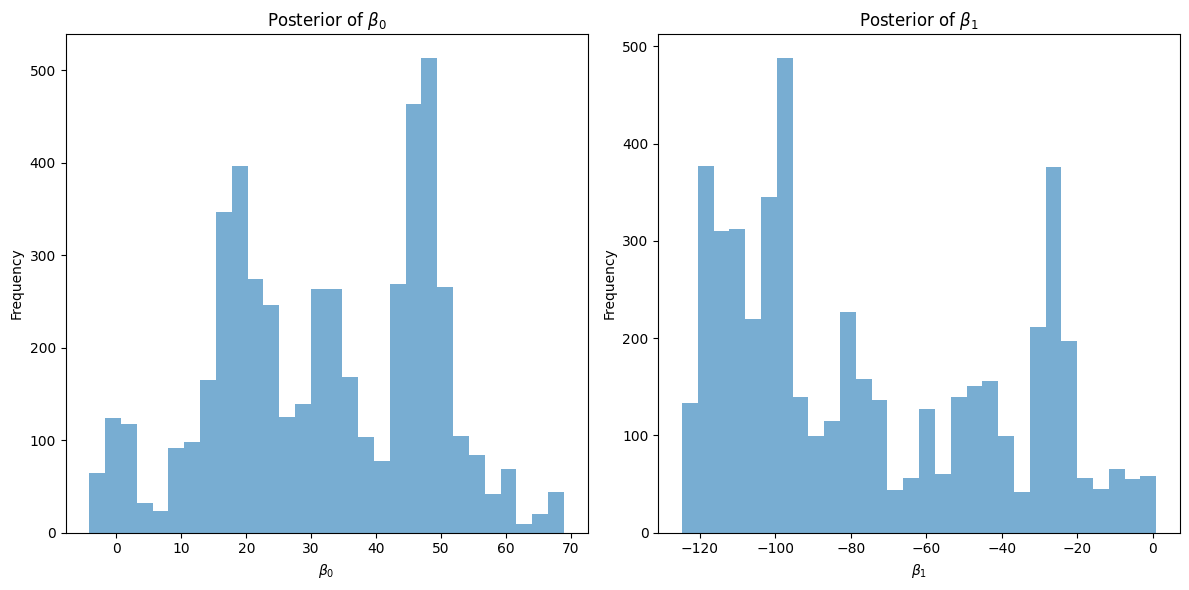

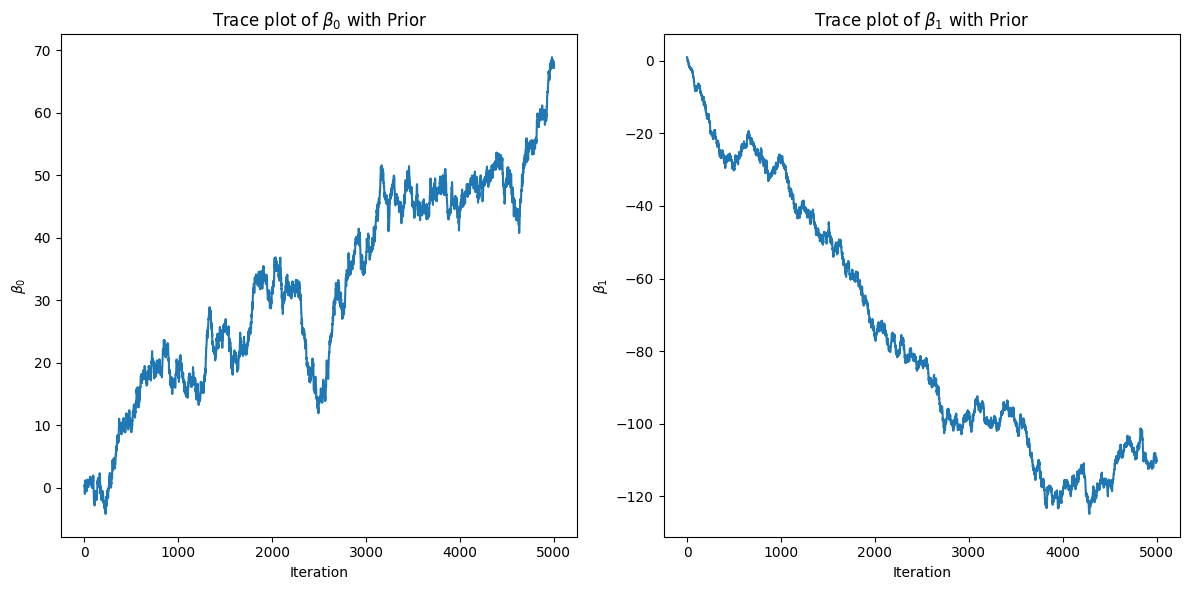

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# ステップ 1: データの準備
np.random.seed(42)  # 再現性のためのシード設定
x = np.array([20, 22, 24, 26, 28, 30, 32])  # 気温
y = np.array([200, 240, 260, 270, 280, 290, 310])  # アイスクリームの売上
n = len(x)

# ステップ 2: MH法によるパラメータ推定
def likelihood(beta_0, beta_1, x, y):
    """尤度関数"""
    y_pred = beta_0 + beta_1 * x
    sigma = np.std(y - y_pred)  # 観測データと予測値の差の標準偏差
    return np.exp(-np.sum((y - y_pred) ** 2) / (2 * sigma ** 2))

def proposal(beta):
    """提案分布"""
    return beta + np.random.normal(0, 0.5, size=beta.shape)

def metropolis_hastings(x, y, iterations=5000):
    beta_samples = np.zeros((iterations, 2))  # [beta_0, beta_1]のサンプルを格納
    beta_current = np.random.rand(2)  # 初期値
    for i in range(iterations):
        beta_proposed = proposal(beta_current)
        probability_ratio = likelihood(beta_proposed[0], beta_proposed[1], x, y) / likelihood(beta_current[0], beta_current[1], x, y)
        if np.random.rand() < probability_ratio:
            beta_current = beta_proposed
        beta_samples[i] = beta_current
    return beta_samples

# MH法でパラメータを推定
beta_samples = metropolis_hastings(x, y, 5000)

# 推定結果のプロット
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(beta_samples[:, 0], bins=30, alpha=0.6)
plt.title('Posterior of $\\beta_0$')
plt.xlabel('$\\beta_0$')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(beta_samples[:, 1], bins=30, alpha=0.6)
plt.title('Posterior of $\\beta_1$')
plt.xlabel('$\\beta_1$')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# トレースプロットの表示
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(beta_samples[:, 0])
plt.title('Trace plot of $\\beta_0$ with Prior')
plt.xlabel('Iteration')
plt.ylabel('$\\beta_0$')

plt.subplot(1, 2, 2)
plt.plot(beta_samples[:, 1])
plt.title('Trace plot of $\\beta_1$ with Prior')
plt.xlabel('Iteration')
plt.ylabel('$\\beta_1$')

plt.tight_layout()
plt.show()

# 事前分布ありver

## 一括

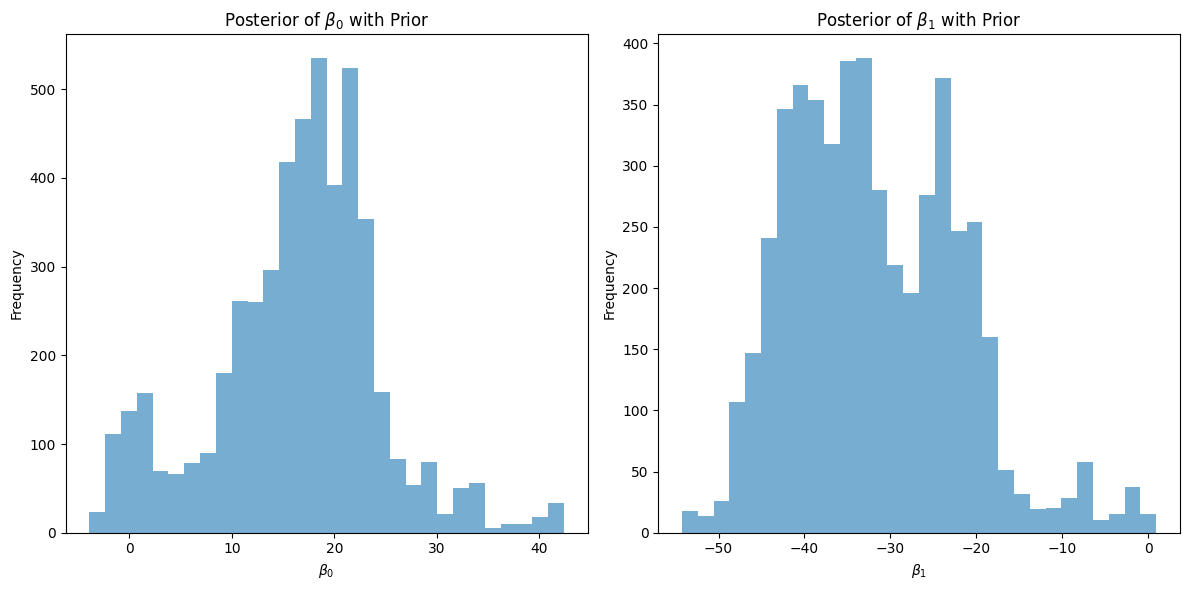

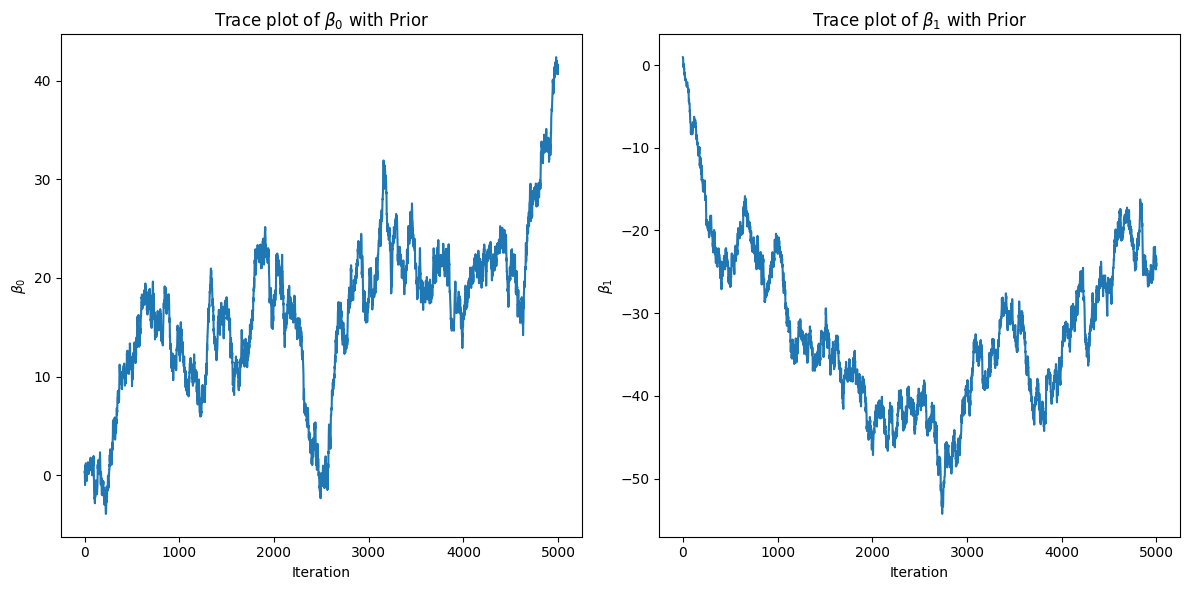

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# データの準備
np.random.seed(42)
x = np.array([20, 22, 24, 26, 28, 30, 32])
y = np.array([200, 240, 260, 270, 280, 290, 310])

def likelihood(beta_0, beta_1, x, y):
    y_pred = beta_0 + beta_1 * x
    sigma = np.std(y - y_pred)
    return np.exp(-np.sum((y - y_pred) ** 2) / (2 * sigma ** 2))

def prior(beta, mu=0, sigma=10):
    return np.exp(-((beta - mu) ** 2) / (2 * sigma ** 2))

def proposal(beta):
    return beta + np.random.normal(0, 0.5, size=beta.shape)

def posterior(beta_0, beta_1, x, y, mu=0, sigma=10):
    return likelihood(beta_0, beta_1, x, y) * prior(beta_0, mu, sigma) * prior(beta_1, mu, sigma)

def metropolis_hastings_with_prior(x, y, iterations=5000, mu=0, sigma=10):
    beta_samples = np.zeros((iterations, 2))
    beta_current = np.random.rand(2)
    for i in range(iterations):
        beta_proposed = proposal(beta_current)
        prob_ratio = posterior(beta_proposed[0], beta_proposed[1], x, y, mu, sigma) / posterior(beta_current[0], beta_current[1], x, y, mu, sigma)
        if np.random.rand() < prob_ratio:
            beta_current = beta_proposed
        beta_samples[i] = beta_current
    return beta_samples

# MH法でパラメータを推定（事前分布を含む）
beta_samples_with_prior = metropolis_hastings_with_prior(x, y, 5000, 0, 10)

# 推定結果のプロット
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(beta_samples_with_prior[:, 0], bins=30, alpha=0.6)
plt.title('Posterior of $\\beta_0$ with Prior')
plt.xlabel('$\\beta_0$')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(beta_samples_with_prior[:, 1], bins=30, alpha=0.6)
plt.title('Posterior of $\\beta_1$ with Prior')
plt.xlabel('$\\beta_1$')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# トレースプロットの表示
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(beta_samples_with_prior[:, 0])
plt.title('Trace plot of $\\beta_0$ with Prior')
plt.xlabel('Iteration')
plt.ylabel('$\\beta_0$')

plt.subplot(1, 2, 2)
plt.plot(beta_samples_with_prior[:, 1])
plt.title('Trace plot of $\\beta_1$ with Prior')
plt.xlabel('Iteration')
plt.ylabel('$\\beta_1$')

plt.tight_layout()
plt.show()

## ステップバイステップ

In [15]:

# データの準備
np.random.seed(42) # 再現性のためのシード設定
x = np.array([20, 22, 24, 26, 28, 30, 32]) # 気温
y = np.array([200, 240, 260, 270, 280, 290, 310]) # アイスクリームの売上
iterations = 5000 # サンプリング回数
mu=0 # 
sigma=10

beta_samples = np.zeros((iterations, 2)) # 格納用の配列
beta_current = np.random.rand(2) # 初期値
print(f'betaの初期値{beta_current}')

i = 0
beta_proposed = proposal(beta_current) # 提案分布からパラメータをサンプリング
print(f'betaの提案値{beta_proposed}')

beta_0_prior = prior(beta_current[0], mu=0, sigma=10) # beta0の事前分布から確率密度を計算
beta_1_prior = prior(beta_current[1], mu=0, sigma=10) # beta1の事前分布から確率密度を計算
print(f'beta0の事前分布の確率密度{beta_0_prior} \nbeta1の事前分布の確率密度{beta_1_prior}')


pre_posterior = posterior(beta_current[0], beta_current[1], x, y, mu, sigma) # 事前分布
post_posterior = posterior(beta_proposed[0], beta_proposed[1], x, y, mu, sigma) # 事後分布
prob_ratio = posterior(beta_proposed[0], beta_proposed[1], x, y, mu, sigma) / posterior(beta_current[0], beta_current[1], x, y, mu, sigma) # 採択率
print(f'採択率{prob_ratio} = 事前分布')


betaの初期値[0.37454012 0.95071431]
betaの提案値[0.69838439 1.71222923]
beta0の事前分布の確率密度0.9992988444214027 
beta1の事前分布の確率密度0.9954909081557703
採択率0.0010748428737227937 = 事前分布


In [8]:
posterior(beta_proposed[0], beta_proposed[1], x, y, mu, sigma)

5.0871579592893774e-104

iterの流れ
- 元パラメータ(初期値 or 前iterでのパラメータ)を決める
- 次のパラメータを提案する
  - 提案分布(今回は初期値を中心とする正規分布)からサンプリングする
- 元パラメータと提案パラメータに対して、尤度と事前分布の確率密度を計算する
  - 尤度とは: データの有り得る度合い、特定のパラメータで今回のデータが得られる確率
    - y-y_predによって予測誤差を計算し、それを元に確率密度を計算する
  - 事前分布の確率密度とは: 特定のパラメータを与えて得た確率分布の確率密度(特定のxに対するyの値)
    - 設定しておいた事前分布において、特定のパラメータはどのくらい有り得るのか？を表す
- 元パラメータと提案パラメータの、尤度と事前分布の確率密度を乗じて、事後分布の確率密度を計算する
- 事後分布の確率密度を元に、提案パラメータを採択するかどうかを決める
  - 提案パラメータの方が事後分布の確率密度が大きければ採択
  - 提案パラメータの方が事後分布の確率密度が小さければ、一定の確率で採択
- こうして採択されたパラメータを次のiterのパラメータとして利用する


# 統合

In [19]:
!pip install japanize_matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 15.1 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=c858aec611eb7381cffa500db1bed8227ab39fd46b645c2624059b75c4b6bd16
  Stored in directory: /home/yusuke_kayahara_zozo_com/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize_matplotlib
